In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['font.size']=20

<Container object of 3 artists>

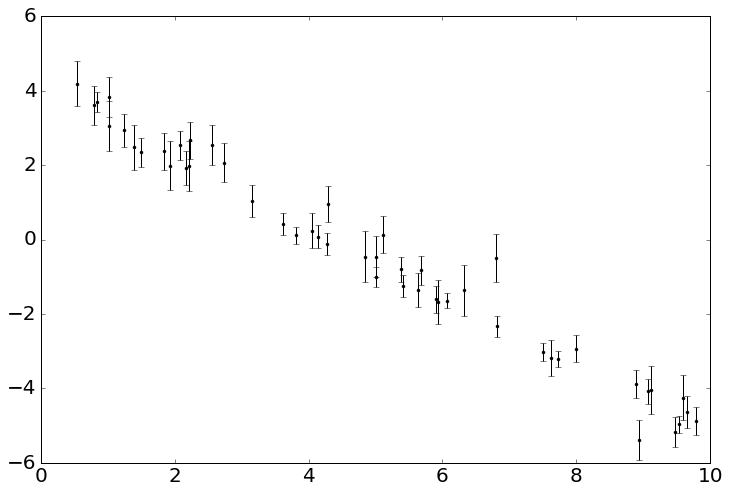

In [2]:
# Generate synthetic data from a model.
# For simplicity, let us assume a LINEAR model y = m*x + b
# where we want to fit m and b
m_true = -0.9594
b_true = 4.294
N = 50

x = np.sort(10*np.random.rand(N))
yerr = 0.2 + 0.5*np.random.rand(N)
y = m_true*x + b_true
y += yerr * np.random.randn(N)

fig = plt.figure()
fig.set_size_inches(12, 8)
plt.errorbar(x, y, yerr=yerr, fmt='.k')

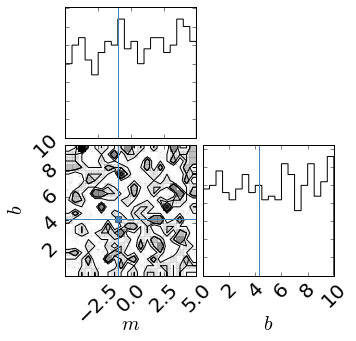

In [17]:
# Now, let's setup some parameters that define the MCMC
ndim = 2
nwalkers = 500

# Initialize the chain
# Choice 1: chain uniformly distributed in the range of the parameters
pos_min = np.array([-5., 0.])
pos_max = np.array([5., 10.])
psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

# Visualize the initialization
import corner
fig = corner.corner(pos, labels=["$m$", "$b$"], extents=[[-5., 5.], [0., 10.]], 
                      truths=[m_true, b_true])
fig.set_size_inches(5,5)

In [18]:
# Define the posterior PDF
# Reminder: post_pdf(theta, data) = likelihood(data, theta) * prior_pdf(theta)
# We take the logarithm since emcee needs it.

# As prior, we assume an 'uniform' prior (i.e. constant prob. density)
def lnprior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

# As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    return -0.5*(np.sum( ((y-model)/yerr)**2. ))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [19]:
# Let us setup the emcee Ensemble Sampler
# It is very simple: just one, self-explanatory line
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [20]:
import time
time0 = time.time()
# burnin phase
pos, prob, state  = sampler.run_mcmc(pos, 300)
sampler.reset()
time1=time.time()
print time1-time0

3.29040503502


In [21]:
time0 = time.time()
# perform MCMC
pos, prob, state  = sampler.run_mcmc(pos, 700)
time1=time.time()
print time1-time0

samples = sampler.flatchain
samples.shape

8.90763401985


(350000, 2)

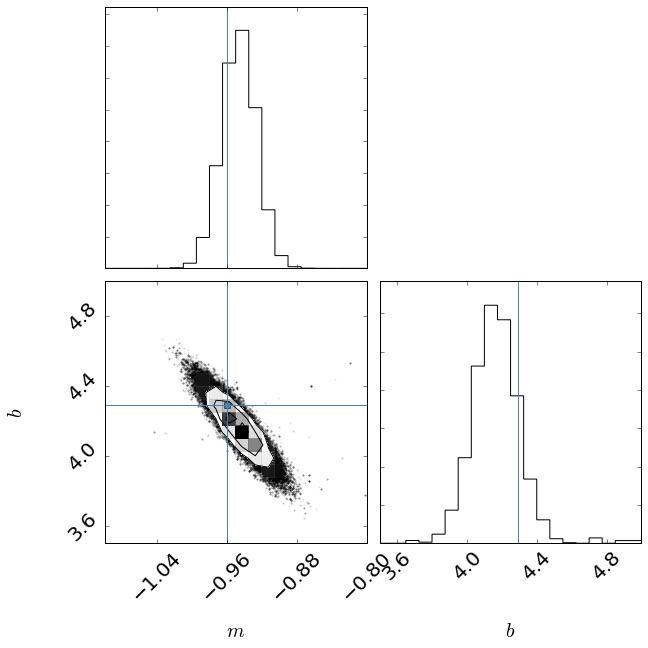

In [23]:
#let's plot the results
fig = corner.corner(samples, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=[m_true, b_true])
fig.set_size_inches(10,10)

array([ 0.49285714,  0.        ,  0.50857143,  0.51714286,  0.54285714,
        0.51142857,  0.        ,  0.51428571,  0.        ,  0.5       ,
        0.        ,  0.50857143,  0.53      ,  0.51857143,  0.53428571,
        0.        ,  0.        ,  0.54142857,  0.        ,  0.53      ,
        0.52142857,  0.55857143,  0.53714286,  0.52428571,  0.52142857,
        0.        ,  0.52428571,  0.48714286,  0.50428571,  0.54571429,
        0.56428571,  0.48      ,  0.        ,  0.49857143,  0.        ,
        0.52857143,  0.48285714,  0.51      ,  0.        ,  0.54428571,
        0.55285714,  0.48857143,  0.        ,  0.54571429,  0.        ,
        0.52142857,  0.50428571,  0.53714286,  0.        ,  0.        ,
        0.53714286,  0.48      ,  0.57      ,  0.52428571,  0.        ,
        0.48285714,  0.48714286,  0.        ,  0.52142857,  0.51285714,
        0.50142857,  0.53      ,  0.53142857,  0.50714286,  0.        ,
        0.19857143,  0.        ,  0.52714286,  0.54142857,  0.50

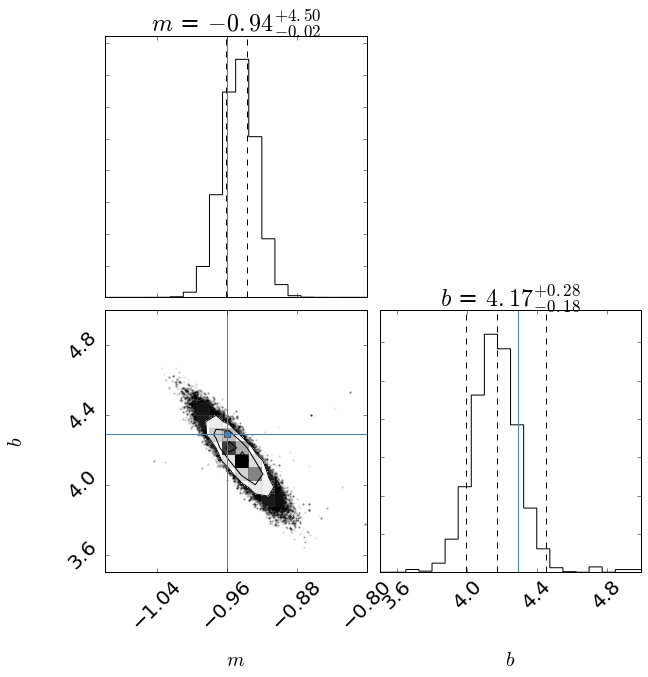

In [24]:
fig = corner.corner(samples, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=[m_true, b_true], quantiles=[0.16, 0.5, 0.84], show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)
sampler.acceptance_fraction

(-6, 6)

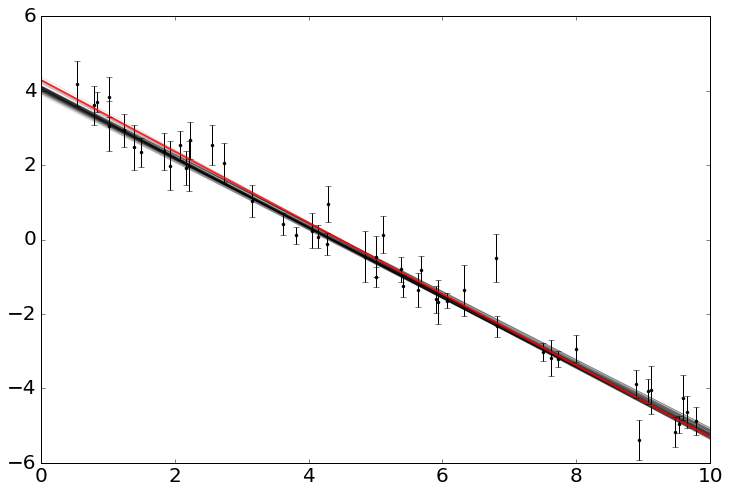

In [25]:
# Plot back the results in the space of data
fig = plt.figure()

xl = np.array([0, 10])
for m, b in samples[-100:]: # samples[np.random.randint(len(samples[-100), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)
plt.ylim(-6,6)